In [ ]:
df.hist('num_imgs', bins=20)

In [ ]:
df.num_imgs.describe()

In [ ]:
len(df[df['num_imgs'] == 0])

In [ ]:
df.plot.scatter('num_imgs', 'log_shares')

In [ ]:
df['one_img'] = np.where(df.num_imgs > 1, 1, 0)
df.boxplot('log_shares', 'one_img')

In [ ]:
df.num_videos.describe()

In [ ]:
df.plot.scatter('num_videos', 'log_shares')

In [ ]:
df.num_links.describe()

In [ ]:
df.plot.scatter('num_links', 'log_shares')

In [ ]:
df.num_self_links.describe()

In [ ]:
df.plot.scatter('num_self_links', 'log_shares')

In [ ]:
df.columns

In [ ]:
df.boxplot('log_shares', 'is_weekend')

In [ ]:
df['average_token_length'] = np.where(df.average_token_length == 0, df.average_token_length.mean(), df.average_token_length)
df.plot.scatter('average_token_length', 'log_shares')

In [ ]:
df.plot.scatter('n_tokens_title', 'shares')

In [ ]:
df.hist('n_tokens_title', bins=20)

In [ ]:
df.hist('average_token_length', bins=20)

In [ ]:
df.hist('n_tokens_content', bins=20)

In [ ]:
df.plot.scatter('n_tokens_content', 'log_shares')

In [ ]:
df.n_tokens_content.describe()

In [ ]:
df['n_tokens_content'] = np.where(df.n_tokens_content == 0, df.n_tokens_content.median(), df.n_tokens_content)
df.plot.scatter('n_tokens_content', 'log_shares')

In [ ]:
df.rate_unique_tokens.describe()

In [ ]:

df.plot.scatter('rate_unique_tokens', 'log_shares')

In [ ]:
df.hist('rate_unique_tokens')

In [ ]:
df['rate_unique_tokens'].corr(df['shares'])

In [ ]:
df.columns

In [ ]:
df['avg_positive_polarity'].corr(df['avg_negative_polarity'])

In [ ]:
df.columns

In [ ]:
df.boxplot('n_tokens_content', 'is_weekend')

In [ ]:
df.columns

In [ ]:
df.plot.scatter('log_shares', 'timedelta')

# Can we predict and maximize article popularity on social media?

# Objectives
Answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
* Do certain genres lead to more popular articles? 
* What effect does the day of publication have?
* Do articles that skew positive, negative, or neutral perform better?
* What effect do our SEO terms have?


## Cleaning and exploring the data
* Import the necessary libraries

In [138]:
import itertools
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

import pickle

from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

from functions import *

* Import the data

In [139]:
df = pd.read_csv('data/online_news_popularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


* Check out column names

In [140]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

* Remove spaces and shorten/clarify some column names

In [141]:
k = list(df.columns)
v = [column.strip() for column in df.columns]

In [142]:
renamer = dict(zip(k, v))
new_names = {'num_hrefs': 'num_links',
             'num_self_hrefs': 'num_self_links',
             'average_token_length': 'avg_token_length',
             'n_unique_tokens': 'rate_unique_tokens',
             'n_non_stop_words': 'rate_non_stop_words',
             'n_non_stop_unique_tokens': 'rate_non_stop_unique_tokens',
             'data_channel_is_lifestyle': 'lifestyle',
             'data_channel_is_entertainment': 'entertainment',
             'data_channel_is_bus': 'business',
             'data_channel_is_socmed': 'social_media',
             'data_channel_is_tech': 'tech',
             'data_channel_is_world': 'world',
             'self_reference_min_shares': 'self_ref_min_shares',
             'self_reference_max_shares': 'self_ref_max_shares',
             'self_reference_avg_sharess': 'self_ref_avg_shares',
             'weekday_is_monday': 'monday',
             'weekday_is_tuesday': 'tuesday',
             'weekday_is_wednesday': 'wednesday',
             'weekday_is_thursday': 'thursday',
             'weekday_is_friday': 'friday',
             'weekday_is_saturday': 'saturday',
             'weekday_is_sunday': 'sunday',
                }

In [143]:
df.rename(columns=renamer, inplace=True)
df.rename(columns=new_names, inplace=True)

In [144]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'rate_unique_tokens', 'rate_non_stop_words',
       'rate_non_stop_unique_tokens', 'num_links', 'num_self_links',
       'num_imgs', 'num_videos', 'avg_token_length', 'num_keywords',
       'lifestyle', 'entertainment', 'business', 'social_media', 'tech',
       'world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_ref_min_shares', 'self_ref_max_shares', 'self_ref_avg_shares',
       'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       'sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity'

* Take a look at the datatypes.
* Change some from floats to integers.

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           39644 non-null  object 
 1   timedelta                     39644 non-null  float64
 2   n_tokens_title                39644 non-null  float64
 3   n_tokens_content              39644 non-null  float64
 4   rate_unique_tokens            39644 non-null  float64
 5   rate_non_stop_words           39644 non-null  float64
 6   rate_non_stop_unique_tokens   39644 non-null  float64
 7   num_links                     39644 non-null  float64
 8   num_self_links                39644 non-null  float64
 9   num_imgs                      39644 non-null  float64
 10  num_videos                    39644 non-null  float64
 11  avg_token_length              39644 non-null  float64
 12  num_keywords                  39644 non-null  float64
 13  l

In [146]:
to_int = ['num_links', 'num_self_links', 'num_imgs', 'num_videos', 'num_keywords', 'lifestyle', 'entertainment',
          'business', 'social_media', 'tech', 'world', 'self_ref_min_shares', 'self_ref_max_shares', 
          'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'is_weekend',
          ]
df[to_int] = df[to_int].astype('int64')

* Take a look at the target variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bb44438>]],
      dtype=object)

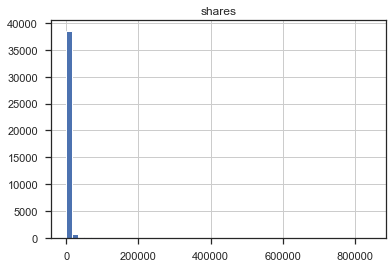

In [147]:
df.hist('shares',bins=50)

* See if the log of 'shares' normalizes it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13aa75940>]],
      dtype=object)

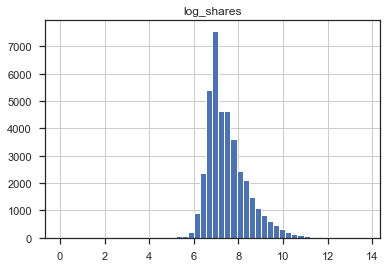

In [148]:
df['log_shares'] = df.shares.apply(lambda x: np.log(x))
df.hist('log_shares', bins=50)

* Investigate the effects of genre and day of the week of publication

In [165]:
genre_cols = ['lifestyle', 'entertainment', 'business', 'social_media', 'tech', 'world']
day_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

df_genres = df[genre_cols]
df_days = df[day_cols]
df_genres_avg = df[genre_cols]
df_days_avg = df[day_cols]

In [168]:
df_genres_avg.head()

,lifestyle,entertainment,business,social_media,tech,world
0,0,593,0,0,0,0
1,0,0,711,0,0,0
2,0,0,1500,0,0,0
3,0,1200,0,0,0,0
4,0,0,0,0,505,0


In [167]:
for col in df_genres_avg.columns:
    df_genres_avg[col] = df_genres_avg[col] * df['shares']

for col in df_days_avg.columns:
    df_days_avg[col] = df_days_avg[col] * df['shares']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [169]:
# df_genres = df_genres.reindex(df_genres.mean().sort_values().index, axis=1)
df_genres_avg = df_genres_avg.reindex(df_genres.sum().sort_values().index, axis=1)
df_genres = df_genres.reindex(df_genres.sum().sort_values().index, axis=1)

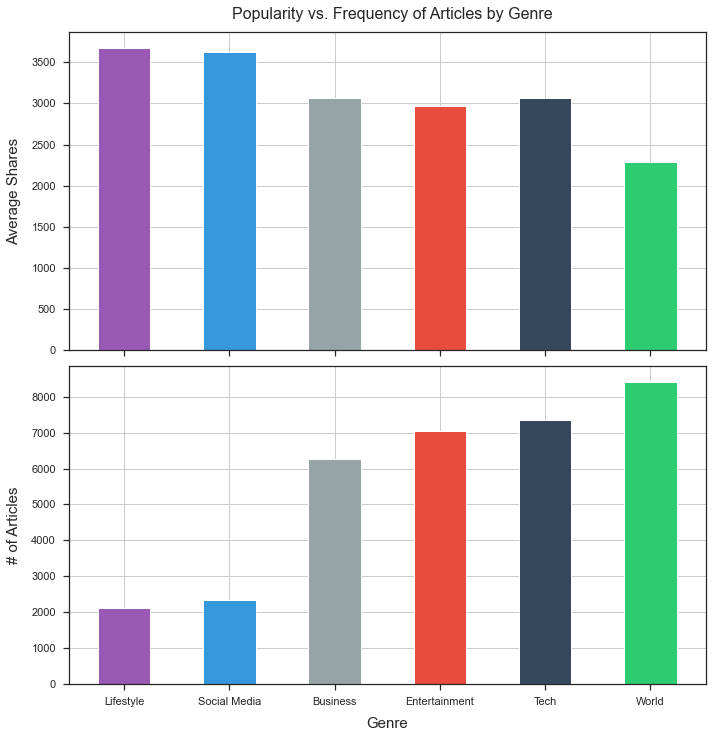

In [217]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,10))
fig.suptitle('Popularity vs. Frequency of Articles by Genre', x=.55, y=1.02, fontsize=16)

genres = [genre.replace('_', ' ').title() for genre in df_genres_avg.columns]
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

ax1.bar(genres, df_genres_avg.sum()/df_genres.sum(), color=colors, width=0.5) 
# ax1.set_title('Average Article Popularity')
ax1.set_ylabel('Average Shares', labelpad=10, fontsize=15)
ax1.grid(True)


ax2.bar(genres, df_genres.sum(), color=colors, width=0.5) 
# ax2.set_title('Genre Frequency')
ax2.set_ylabel('# of Articles', labelpad=10, fontsize=15)
ax2.set_xlabel('Genre', labelpad=10, fontsize=15)
ax2.grid(True)


plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 

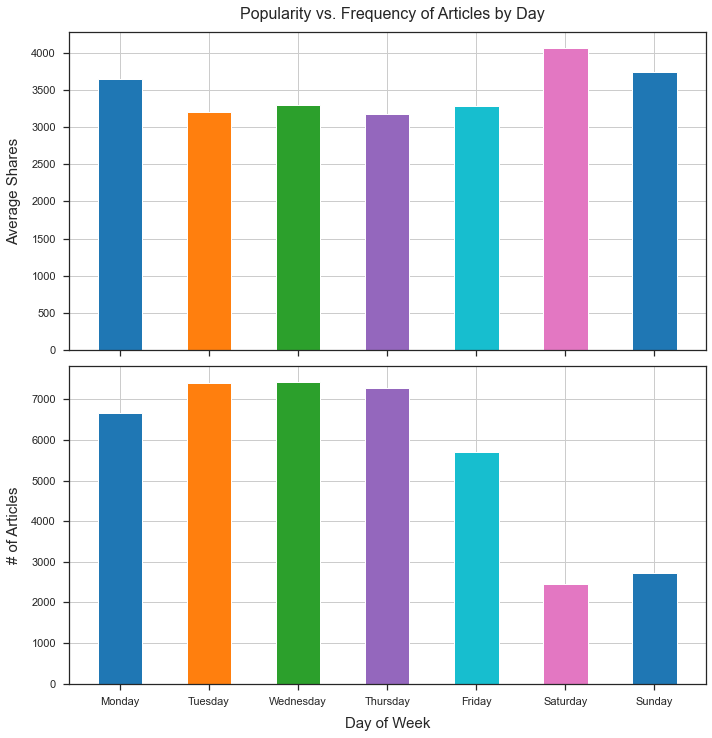

In [222]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,10))
fig.suptitle('Popularity vs. Frequency of Articles by Day', x=.55, y=1.02, fontsize=16)

days = [day.title() for day in df_days_avg.columns]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:cyan", "tab:pink"]

ax1.bar(days, df_days_avg.sum()/df_days_avg.astype(bool).sum(axis=0), color=colors, width=0.5) 
ax1.set_ylabel('Average Shares', labelpad=10, fontsize=15)
ax1.grid(True)


ax2.bar(days, df_days.sum(), color=colors, width=0.5) 
# ax2.set_title('Genre Frequency')
ax2.set_ylabel('# of Articles', labelpad=10, fontsize=15)
ax2.set_xlabel('Day of Week', labelpad=10, fontsize=15)
ax2.grid(True)


plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 

In [ ]:
df.boxplot('log_shares', 'lifestyle')

* Drop unnecessary columns, one dummy column from each category (genres, days of the week, and LDA), and columns with unknown values.

In [47]:
df.drop(columns=[
                 'url', 'timedelta', 'shares', 'self_ref_min_shares', 'self_ref_max_shares', # unnecessary columns
                 'monday', 'lifestyle', 'LDA_00', # remove one dummy variable from genres and days of the week
                 'kw_max_max', 'kw_min_min', 'rate_non_stop_words' # unknown values
                                            ], inplace=True)

* See if anything is too correlated, and if so, drop those columns.

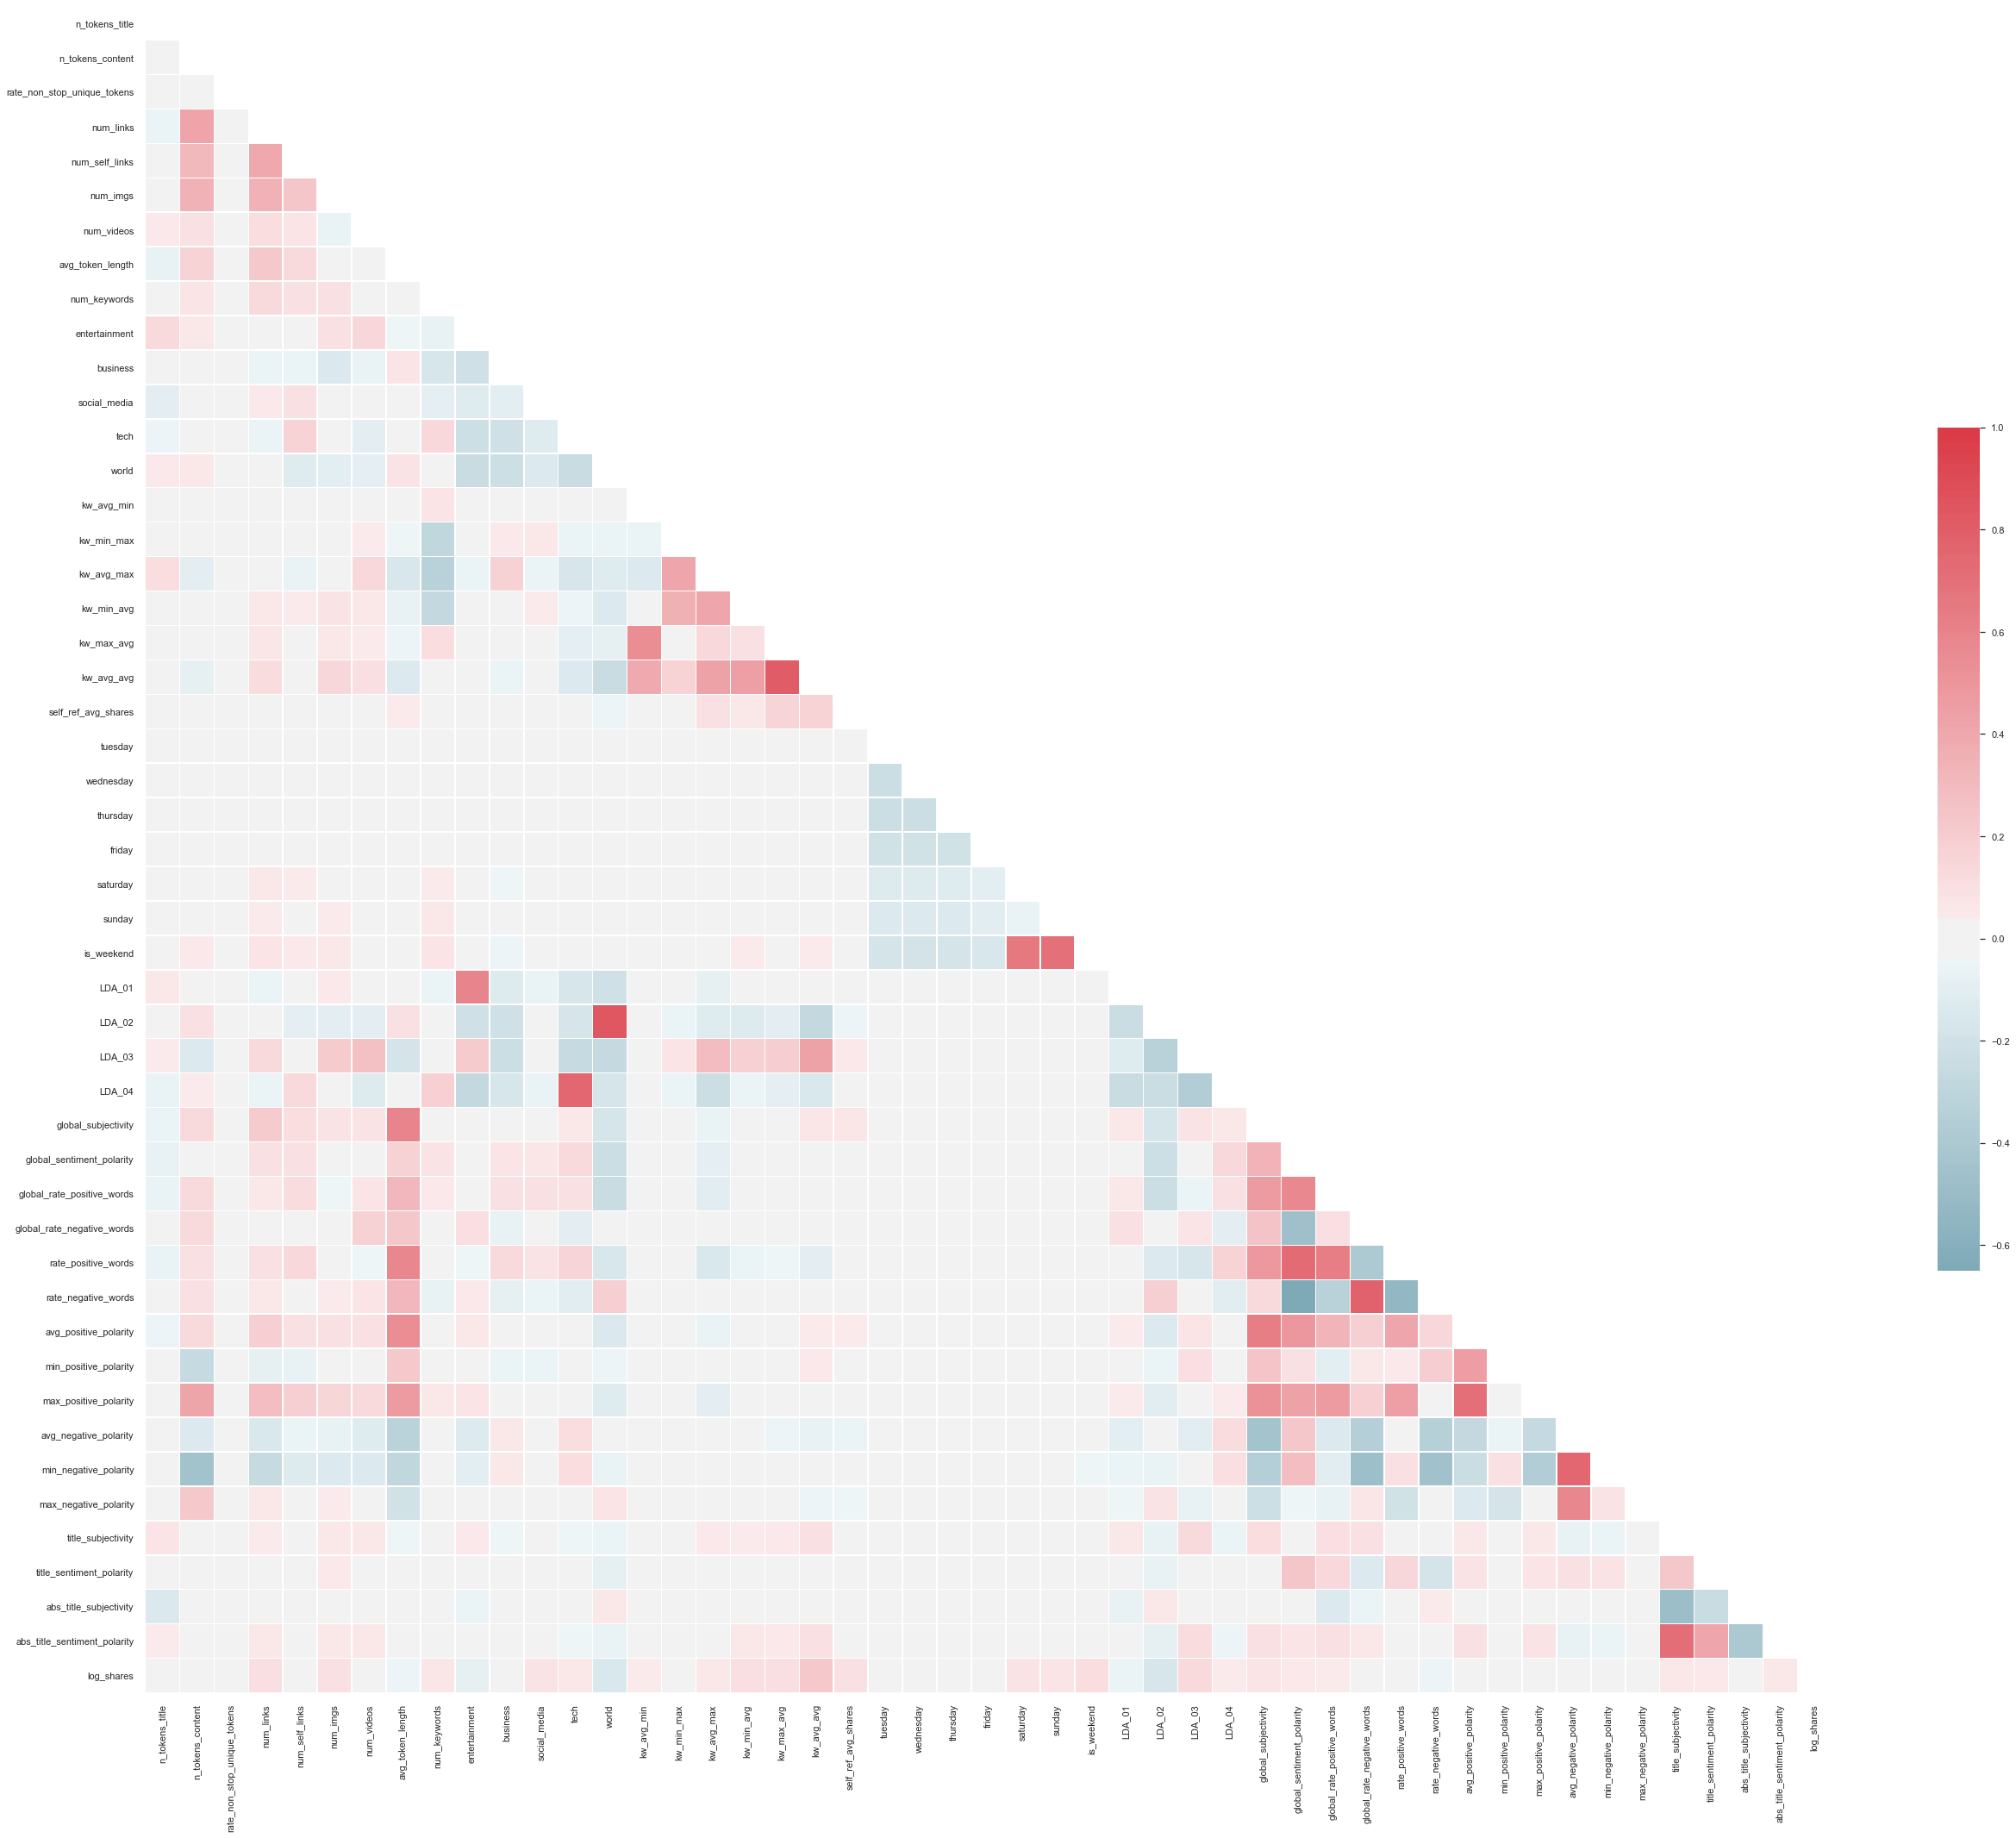

In [49]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
df.drop(columns=['rate_unique_tokens', 'kw_max_min'], inplace=True)

* Data seems pretty clean, so let's have a preliminary look at some modeling numbers.

In [50]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     118.9
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        17:52:49   Log-Likelihood:                -50779.
No. Observations:               39644   AIC:                         1.017e+05
Df Residuals:                   39596   BIC:                         1.021e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.9906      0.057    122.393      0.000       6.879       7.103
n_tokens_title                   0.0072      0.002      3.305      0.001       0.003       0.011
n_tokens_content               3.67e-05   1.39e-05      2.648      0.008    9.54e-06    6.39e-05
rate_non_stop_unique_tokens      0.0023      0.001      1.714      0.087      -0.000       0.005
num_links                        0.0042      0.001      8.441      0.000       0.003       0.005
num_self_links                  -0.0078      0.001     -5.935      0.000      -0.010      -0.005
num_imgs                         0.0030      0.001      4.780      0.000       0.002       0.004
num_videos                       0.0031      0.001      2.592      0.010       0.001       0.005
avg_token_length                -0.0837      0.017     -4.833      0.000      -0.118      -0.050
num_keywords                     0.0079      0.003      2.906      0.004       0.003       0.013
entertainment                   -0.1941      0.018    -11.016      0.000      -0.229      -0.160
business                        -0.1134      0.024     -4.673      0.000      -0.161      -0.066
social_media                     0.1871      0.024      7.737      0.000       0.140       0.234
tech                             0.1575      0.020      7.773      0.000       0.118       0.197
world                           -0.0167      0.024     -0.696      0.487      -0.064       0.030
kw_avg_min                   -2.395e-05    8.8e-06     -2.721      0.007   -4.12e-05    -6.7e-06
kw_min_max                   -2.146e-07   8.66e-08     -2.479      0.013   -3.84e-07   -4.49e-08
kw_avg_max                    -5.32e-07   4.84e-08    -10.998      0.000   -6.27e-07   -4.37e-07
kw_min_avg                   -4.455e-05   5.63e-06     -7.907      0.000   -5.56e-05   -3.35e-05
kw_max_avg                   -3.905e-05   1.79e-06    -21.853      0.000   -4.26e-05   -3.56e-05
kw_avg_avg                       0.0003   1.04e-05     30.643      0.000       0.000       0.000
self_ref_avg_shares           1.951e-06   1.85e-07     10.536      0.000    1.59e-06    2.31e-06
tuesday                         -0.0675      0.015     -4.578      0.000      -0.096      -0.039
wednesday                       -0.0637      0.015     -4.326      0.000      -0.093      -0.035
thursday                        -0.0574      0.015     -3.878      0.000      -0.086      -0.028
friday                           0.0047      0.016      0.301      0.763      -0.026       0.036
saturday                         0.0743      0.014      5.500      0.000       0.048       0.101
sunday                           0.0716      0.013      5.462      0.000       0.046       0.097
is_weekend                       0.1458      0.011     13.424      0.000    

* R<sup>2</sup> value is very low (0.124), so let's see if we can bring it up a bit.
* Some of our coefficients are on a wildly different scale, so let's see if a log transformation helps with those.
* A closer look at some of the columns shows some suspicious values of 0 and 1 for the rate of certain tokens and token types. Also some values are below 1 for columns that measure in article shares, even though the minimum value for shares is 1.
    * Reassign those 0s and 1s to each column's median value.
    * Reassign any less-than 1s in columns measuring in shares to 1.
    * Transform data measured in number of shares to their logarithm.

In [57]:
less_set_to_one_cols = ['kw_avg_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
                        'kw_avg_avg', 'self_ref_avg_shares', 'n_tokens_content']

zero_to_median_cols = ['avg_token_length', 'n_tokens_content', 'global_subjectivity', 'global_rate_positive_words',
                       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'avg_negative_polarity']

one_to_median_cols = ['rate_non_stop_unique_tokens', 'rate_positive_words', 'rate_negative_words', 
                      'avg_positive_polarity']

In [59]:
for column in less_set_to_one_cols:
    less_set_to_one(df, column)  
    
for column in zero_to_median_cols:
    zero_to_median(df, column)
    
for column in one_to_median_cols:
    one_to_median(df, column)

great_set_to_one(df, 'rate_non_stop_unique_tokens')
    
neg_one_to_median(df, 'avg_negative_polarity')

for column in less_set_to_one_cols:
    log_col(df, column)

In [60]:
df.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'num_videos', 'avg_token_length',
       'num_keywords', 'entertainment', 'business', 'social_media', 'tech',
       'world', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       'sunday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'log_shares', 'log_kw_avg_min',
       'log_kw_min_max', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'log

In [61]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     114.2
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:02:33   Log-Likelihood:                -50926.
No. Observations:               39644   AIC:                         1.019e+05
Df Residuals:                   39597   BIC:                         1.023e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.5972      3.129      1.469      0.142      -1.536      10.730
n_tokens_title                   0.0070      0.002      3.210      0.001       0.003       0.011
rate_non_stop_unique_tokens     -0.1999      0.043     -4.670      0.000      -0.284      -0.116
num_links                        0.0058      0.001     11.510      0.000       0.005       0.007
num_self_links                  -0.0150      0.001    -10.852      0.000      -0.018      -0.012
num_imgs                         0.0029      0.001      4.449      0.000       0.002       0.004
num_videos                       0.0017      0.001      1.437      0.151      -0.001       0.004
avg_token_length                -0.0655      0.018     -3.739      0.000      -0.100      -0.031
num_keywords                     0.0096      0.003      3.440      0.001       0.004       0.015
entertainment                   -0.2799      0.017    -16.260      0.000      -0.314      -0.246
business                        -0.1615      0.024     -6.676      0.000      -0.209      -0.114
social_media                     0.1404      0.024      5.821      0.000       0.093       0.188
tech                             0.1150      0.020      5.675      0.000       0.075       0.155
world                           -0.0773      0.024     -3.214      0.001      -0.124      -0.030
tuesday                         -0.0779      0.015     -5.256      0.000      -0.107      -0.049
wednesday                       -0.0787      0.015     -5.316      0.000      -0.108      -0.050
thursday                        -0.0689      0.015     -4.628      0.000      -0.098      -0.040
friday                          -0.0023      0.016     -0.147      0.883      -0.033       0.029
saturday                         0.0740      0.014      5.462      0.000       0.047       0.101
sunday                           0.0700      0.013      5.323      0.000       0.044       0.096
is_weekend                       0.1440      0.011     13.187      0.000       0.123       0.165
LDA_01                          -0.2659      0.038     -6.972      0.000      -0.341      -0.191
LDA_02                          -0.4718      0.038    -12.437      0.000      -0.546      -0.397
LDA_03                          -0.1746      0.035     -5.032      0.000      -0.243      -0.107
LDA_04                          -0.2939      0.034     -8.564      0.000      -0.361      -0.227
global_subjectivity              0.5091      0.063      8.079      0.000       0.386       0.633
global_sentiment_polarity       -0.3295      0.115     -2.857      0.004      -0.556      -0.103
global_rate_positive_words      -0.7136      0.549     -1.299      0.194      -1.790       0.363
global_rate_negative_words       1.0433      1.044      0.999      0.318    

* Hm, a lower R<sup>2</sup>, but the scale of the coefficients looks way better.
* Let's remove some extreme values.
* Then let's categorize the image and video columns, since the number itself doesn't seem to hold much value.

In [62]:
extreme_cols = find_extremes(df)
extreme_cols.remove('log_shares')
df[extreme_cols].describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,social_media,global_subjectivity,global_subjectivity,...,title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_avg_min,log_kw_avg_max,log_kw_max_avg,log_kw_max_avg,log_kw_avg_avg,log_kw_avg_avg,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,0.672805,10.883690,3.293638,4.544143,1.249874,4.687183,0.058597,0.456913,0.456913,...,0.071425,7.474855,5.285117,5.285117,12.241858,8.482530,8.482530,7.975971,7.975971,5.887062
std,2.114037,0.154042,11.332017,3.855141,8.309434,4.107855,0.279009,0.234871,0.086970,0.086970,...,0.265450,0.930486,1.159682,1.159682,0.943071,0.582098,0.582098,0.489534,0.489534,1.256215
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,0.022222,0.022222,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,0.000000,0.404489,0.404489,...,0.000000,6.852243,4.954065,4.954065,12.060161,8.178106,8.178106,7.775884,7.775884,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,0.000000,0.453458,0.453458,...,0.000000,7.244228,5.461711,5.461711,12.407266,8.379238,8.379238,7.962093,7.962093,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,0.000000,0.508333,0.508333,...,0.150000,7.937375,5.877736,5.877736,12.709813,8.702835,8.702835,8.188753,8.188753,6.573680
max,23.000000,1.000000,304.000000,116.000000,128.000000,91.000000,8.041534,1.000000,1.000000,1.000000,...,1.000000,13.645078,10.664944,10.664944,13.645078,12.606190,12.606190,10.682070,10.682070,9.044758


In [63]:
rein_extremes(df, extreme_cols)
df.describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,num_keywords,entertainment,business,...,abs_title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_min_max,log_kw_avg_max,log_kw_min_avg,log_kw_max_avg,log_kw_avg_avg,log_self_ref_avg_shares,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398565,0.674492,10.671710,3.193118,4.369646,1.109187,4.686590,7.223767,0.178009,0.157855,...,0.156064,7.473784,5.308137,5.045032,12.259005,4.258814,8.491980,7.988524,6.667274,5.912747
std,2.113181,0.146803,9.909757,3.137274,7.214085,3.052417,0.275593,1.909130,0.382525,0.364610,...,0.226294,0.922311,1.058561,4.520923,0.785279,3.726459,0.428693,0.337462,3.280200,1.138918
min,2.000000,0.056637,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,...,0.000000,3.752911,0.943081,0.000000,8.469573,0.000000,6.711233,6.603144,0.000000,0.862203
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,6.000000,0.000000,0.000000,...,0.000000,6.852243,4.954065,0.000000,12.060161,0.000000,8.178106,7.775884,6.888764,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,7.000000,0.000000,0.000000,...,0.000000,7.244228,5.461711,7.244228,12.407266,6.931116,8.379238,7.962093,7.696213,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,0.000000,0.000000,...,0.250000,7.937375,5.877736,8.974618,12.709813,7.628897,8.702835,8.188753,8.556414,6.573680
max,18.854896,1.000000,56.211759,18.714203,37.781877,17.681294,5.803220,10.000000,1.000000,1.000000,...,1.000000,11.196799,9.658672,13.645078,13.645078,8.192305,10.275553,9.372541,13.645078,9.044758


In [64]:
df['has_img'] = np.where(df.num_imgs > 0, 1, 0)
df['has_video'] = np.where(df.num_videos > 0, 1, 0)

In [71]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     128.5
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:13:09   Log-Likelihood:                -50175.
No. Observations:               39644   AIC:                         1.004e+05
Df Residuals:                   39595   BIC:                         1.009e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.3945      3.177      0.439      0.661      -4.833       7.622
n_tokens_title                   0.0050      0.002      2.346      0.019       0.001       0.009
rate_non_stop_unique_tokens     -0.2038      0.044     -4.625      0.000      -0.290      -0.117
num_links                        0.0060      0.001     10.333      0.000       0.005       0.007
num_self_links                  -0.0178      0.002    -10.255      0.000      -0.021      -0.014
num_imgs                         0.0036      0.001      4.597      0.000       0.002       0.005
num_videos                      -0.0034      0.002     -1.936      0.053      -0.007    4.18e-05
avg_token_length                -0.0572      0.018     -3.260      0.001      -0.092      -0.023
num_keywords                     0.0014      0.003      0.494      0.622      -0.004       0.007
entertainment                   -0.1980      0.017    -11.433      0.000      -0.232      -0.164
business                        -0.0869      0.024     -3.636      0.000      -0.134      -0.040
social_media                     0.1807      0.024      7.596      0.000       0.134       0.227
tech                             0.1644      0.020      8.208      0.000       0.125       0.204
world                           -0.0060      0.024     -0.253      0.800      -0.053       0.041
tuesday                         -0.0654      0.015     -4.499      0.000      -0.094      -0.037
wednesday                       -0.0623      0.015     -4.295      0.000      -0.091      -0.034
thursday                        -0.0534      0.015     -3.658      0.000      -0.082      -0.025
friday                           0.0137      0.016      0.881      0.378      -0.017       0.044
saturday                         0.0756      0.013      5.687      0.000       0.050       0.102
sunday                           0.0760      0.013      5.891      0.000       0.051       0.101
is_weekend                       0.1516      0.011     14.170      0.000       0.131       0.173
LDA_01                          -0.2994      0.038     -7.974      0.000      -0.373      -0.226
LDA_02                          -0.3888      0.037    -10.394      0.000      -0.462      -0.315
LDA_03                          -0.2852      0.034     -8.266      0.000      -0.353      -0.218
LDA_04                          -0.2441      0.034     -7.231      0.000      -0.310      -0.178
global_subjectivity              0.4369      0.062      7.004      0.000       0.315       0.559
global_sentiment_polarity       -0.3161      0.114     -2.767      0.006      -0.540      -0.092
global_rate_positive_words      -0.8450      0.566     -1.492      0.136      -1.955       0.265
global_rate_negative_words       1.3971      1.124      1.243      0.214    

* Drop any variables with high p-values.

In [74]:
df_test = df.drop(columns=['num_videos', 'num_keywords', 'world', 'friday', 'global_rate_positive_words',
                           'global_rate_negative_words', 'rate_negative_words', 'min_negative_polarity',
                           'max_negative_polarity', 'max_positive_polarity', 'avg_negative_polarity', 
                           'avg_positive_polarity', 'abs_title_sentiment_polarity', 'log_kw_min_max',
                           'log_n_tokens_content'])

In [75]:
test_features = list(df_test.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     180.9
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:16:36   Log-Likelihood:                -50184.
No. Observations:               39644   AIC:                         1.004e+05
Df Residuals:                   39609   BIC:                         1.007e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.9358      0.177     16.552      0.000       2.588       3.283
n_tokens_title                  0.0050      0.002      2.328      0.020       0.001       0.009
rate_non_stop_unique_tokens    -0.2345      0.036     -6.536      0.000      -0.305      -0.164
num_links                       0.0058      0.001     10.942      0.000       0.005       0.007
num_self_links                 -0.0181      0.002    -10.505      0.000      -0.021      -0.015
num_imgs                        0.0036      0.001      4.808      0.000       0.002       0.005
avg_token_length               -0.0580      0.017     -3.377      0.001      -0.092      -0.024
entertainment                  -0.2005      0.016    -12.394      0.000      -0.232      -0.169
business                       -0.0884      0.022     -4.035      0.000      -0.131      -0.045
social_media                    0.1795      0.022      8.280      0.000       0.137       0.222
tech                            0.1646      0.018      9.226      0.000       0.130       0.200
tuesday                        -0.0722      0.013     -5.712      0.000      -0.097      -0.047
wednesday                      -0.0687      0.013     -5.451      0.000      -0.093      -0.044
thursday                       -0.0601      0.013     -4.729      0.000      -0.085      -0.035
saturday                        0.0738      0.013      5.642      0.000       0.048       0.099
sunday                          0.0738      0.013      5.829      0.000       0.049       0.099
is_weekend                      0.1476      0.010     15.473      0.000       0.129       0.166
LDA_01                         -0.2942      0.037     -7.933      0.000      -0.367      -0.222
LDA_02                         -0.3949      0.033    -11.818      0.000      -0.460      -0.329
LDA_03                         -0.2841      0.033     -8.516      0.000      -0.349      -0.219
LDA_04                         -0.2427      0.034     -7.224      0.000      -0.309      -0.177
global_subjectivity             0.4744      0.057      8.372      0.000       0.363       0.585
global_sentiment_polarity      -0.3455      0.074     -4.673      0.000      -0.490      -0.201
rate_positive_words             0.1828      0.051      3.569      0.000       0.082       0.283
min_positive_polarity          -0.2554      0.078     -3.266      0.001      -0.409      -0.102
title_subjectivity              0.0646      0.016      4.086      0.000       0.034       0.096
title_sentiment_polarity        0.0824      0.018      4.710      0.000       0.048       0.117
abs_title_subjectivity          0.1289      0.027      4.797      0.000       0.076       0.182
log_kw_avg_min                  0.0143      0.005      3.032      0.002       0.005       0.024
log_kw_avg_

* The best R<sup>2</sup> yet! Reining in the extreme values gave us a 6% bump.

In [79]:
features = df_test.copy()

In [80]:
features.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'avg_token_length', 'entertainment',
       'business', 'social_media', 'tech', 'tuesday', 'wednesday', 'thursday',
       'saturday', 'sunday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'rate_positive_words', 'min_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity', 'log_shares',
       'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'has_img', 'has_video'],
      dtype='object')

In [121]:
target = features['log_shares']
features_only = features.drop(columns='log_shares')
X_train, X_test, y_train, y_test = train_test_split(features_only, target, random_state=42, test_size=0.2)
# random_state=22,

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
regression = LinearRegression()

In [84]:
continuous = ['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
               'num_self_links', 'num_imgs', 'avg_token_length', 'LDA_01', 'LDA_02', 'LDA_03',
               'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
               'rate_positive_words', 'min_positive_polarity', 'title_subjectivity',
               'title_sentiment_polarity', 'abs_title_subjectivity',
               'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
               'log_kw_avg_avg', 'log_self_ref_avg_shares']
categoricals = ['entertainment', 'business', 'social_media', 'tech', 'tuesday', 'wednesday', 'thursday',
                'saturday', 'sunday', 'is_weekend', 'has_img', 'has_video']

target = y_train.copy()

features_cont = X_train[continuous]

# log features
log_names = [f'{column}_log' for column in features_cont.columns]

features_log = np.log(features_cont)
features_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_log_norm = features_log.apply(normalize)

features_cat = X_train[categoricals]

preprocessed = pd.concat([target, features_cont, features_cat], axis=1)

X = preprocessed.drop('log_shares', axis=1)
y = preprocessed['log_shares']

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


0.13165745283252916

In [85]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
100
150
200
250
300
350
400
450
500
550
Top 3 interactions: [('log_kw_min_avg', 'log_kw_avg_avg', 0.134), ('num_self_links', 'num_imgs', 0.133), ('num_self_links', 'log_self_ref_avg_shares', 0.133)]


In [ ]:
with open('train_interactions_list.pickle', 'wb') as f:
    pickle.dump(interactions, f)

In [ ]:
# with open('train_interactions_list.pickle', 'rb') as file:
#     interactions = pickle.load(file)

In [86]:
len(interactions)

241

In [87]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
max_r_squared = X.copy()

for i in interactions:
    max_r_squared[i[0]+'_'+i[1]] = max_r_squared[i[0]] * max_r_squared[i[1]]

max_r2_model = np.mean(cross_val_score(regression, max_r_squared, y, scoring='r2', cv=crossvalidation))

max_r2_model

0.1534925799984829

In [88]:
max_r2_target = pd.concat([target, max_r_squared], axis=1)

In [89]:
f_list = list(max_r2_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model = ols(formula=f, data=max_r2_target).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     23.97
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:48:19   Log-Likelihood:                -39501.
No. Observations:               31715   AIC:                         7.954e+04
Df Residuals:                   31446   BIC:                         8.179e+04
Df Model:                         268                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -6.6928      2.752     -2.432      0.015     -12.086      -1.299
n_tokens_title                                      -0.0911      0.046     -1.976      0.048      -0.181      -0.001
rate_non_stop_unique_tokens                          0.0857      0.377      0.227      0.820      -0.654       0.825
num_links                                           -0.0044      0.014     -0.313      0.754      -0.032       0.023
num_self_links                                       0.0342      0.062      0.549      0.583      -0.088       0.157
num_imgs                                            -0.0137      0.025     -0.543      0.587      -0.063       0.036
avg_token_length                                     0.7337      0.334      2.198      0.028       0.079       1.388
LDA_01                                              -0.5014      0.690     -0.727      0.467      -1.854       0.851
LDA_02                                               3.7917      0.870      4.356      0.000       2.086       5.498
LDA_03                                              -0.6295      0.590     -1.068      0.286      -1.785       0.526
LDA_04                                              -0.5024      0.622     -0.807      0.420      -1.722       0.718
global_subjectivity                                  1.0100      1.201      0.841      0.400      -1.345       3.365
global_sentiment_polarity                           -0.3243      1.388     -0.234      0.815      -3.044       2.396
rate_positive_words                                 -0.4617      0.358     -1.289      0.198      -1.164       0.241
min_positive_polarity                               -0.9125      1.415     -0.645      0.519      -3.686       1.861
title_subjectivity                                  -0.1251      0.319     -0.392      0.695      -0.750       0.500
title_sentiment_polarity                             0.1105      0.364      0.303      0.762      -0.603       0.824
abs_title_subjectivity                              -0.3161      0.238     -1.331      0.183      -0.782       0.149
log_kw_avg_min                                      -0.1620      0.102     -1.581      0.114      -0.363       0.039
log_kw_avg_max                                      -0.9658      0.226     -4.269      0.000      -1.409      -0.522
log_kw_min_avg                                      -0.4806      0.059     -8.121      0.000      -0.597      -0.365
log_kw_max_avg                                       2.7759      0.416      6.678      0.000       1.961       3.591
log_kw_avg_avg                                       1.5557      0.533      2.917      0.004       0.510       2.601
log_self_ref_avg_shares                  

* R-squared value has gone from 0.127 to 0.183, or a 44.1% increase!
* Unfortunately the number of features is far more than the square root (178) of our sample size. Let's simplify and go for the top 100.

In [90]:
np.sqrt(len(X_train))

178.08705736240353

In [91]:
top_100 = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:100]
top_100[-10:]

[('avg_token_length', 'min_positive_polarity', 0.132),
 ('avg_token_length', 'title_subjectivity', 0.132),
 ('avg_token_length', 'title_sentiment_polarity', 0.132),
 ('avg_token_length', 'log_kw_avg_max', 0.132),
 ('avg_token_length', 'log_kw_min_avg', 0.132),
 ('avg_token_length', 'log_self_ref_avg_shares', 0.132),
 ('avg_token_length', 'entertainment', 0.132),
 ('avg_token_length', 'business', 0.132),
 ('avg_token_length', 'tech', 0.132),
 ('avg_token_length', 'wednesday', 0.132)]

In [92]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

for i in top_100:
    X_train[i[0]+'_'+i[1]] = X_train[i[0]] * X_train[i[1]]

final_model = np.mean(cross_val_score(regression, X_train, y, scoring='r2', cv=crossvalidation))

final_model

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.14664860894746107

In [93]:
final_target = pd.concat([target, X_train], axis=1)

In [94]:
f_list = list(final_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model = ols(formula=f, data=final_target).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     43.76
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        18:48:53   Log-Likelihood:                -39786.
No. Observations:               31715   AIC:                         7.984e+04
Df Residuals:                   31582   BIC:                         8.095e+04
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           2.9345      2.253      1.302      0.193      -1.482       7.351
n_tokens_title                                     -0.0900      0.046     -1.973      0.049      -0.179      -0.001
rate_non_stop_unique_tokens                         0.0495      0.371      0.133      0.894      -0.678       0.777
num_links                                           0.0050      0.014      0.364      0.716      -0.022       0.032
num_self_links                                     -0.0171      0.060     -0.283      0.777      -0.135       0.101
num_imgs                                           -0.0277      0.024     -1.170      0.242      -0.074       0.019
avg_token_length                                    0.7235      0.321      2.253      0.024       0.094       1.353
entertainment                                      -0.7316      0.288     -2.541      0.011      -1.296      -0.167
business                                           -1.9808      0.515     -3.844      0.000      -2.991      -0.971
social_media                                        1.2456      0.183      6.794      0.000       0.886       1.605
tech                                                0.0288      0.348      0.083      0.934      -0.654       0.711
tuesday                                            -0.1963      0.065     -3.013      0.003      -0.324      -0.069
wednesday                                           0.0795      0.219      0.363      0.717      -0.350       0.509
thursday                                            0.0051      0.065      0.079      0.937      -0.123       0.133
saturday                                            0.0853      0.105      0.812      0.417      -0.121       0.291
sunday                                             -0.0916      0.104     -0.885      0.376      -0.295       0.111
is_weekend                                         -0.0063      0.072     -0.088      0.930      -0.148       0.135
LDA_01                                             -0.6735      0.141     -4.762      0.000      -0.951      -0.396
LDA_02                                              0.9154      0.506      1.810      0.070      -0.076       1.907
LDA_03                                             -1.3518      0.440     -3.071      0.002      -2.215      -0.489
LDA_04                                             -0.6497      0.545     -1.191      0.234      -1.719       0.419
global_subjectivity                                 1.4554      1.155      1.260      0.208      -0.809       3.720
global_sentiment_polarity                          -0.2530      1.011     -0.250      0.802      -2.234       1.728
rate_positive_words                                -0.1426      0.2

In [95]:
for i in top_100:
    X_test[i[0]+'_'+i[1]] = X_test[i[0]] * X_test[i[1]]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [123]:
orig_list = list(X_train.columns)
orig_list.remove('log_shares')

ValueError: list.remove(x): x not in list

In [124]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)

In [125]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = np.exp(lm.predict(X_train))

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = np.exp(lm.predict(X_test))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Training Root Mean Squared Error: 1979.6939515183935
Testing Root Mean Squared Error: 1978.5252215240598
Training:  1979.6939515183935 vs. Testing:  1978.5252215240598


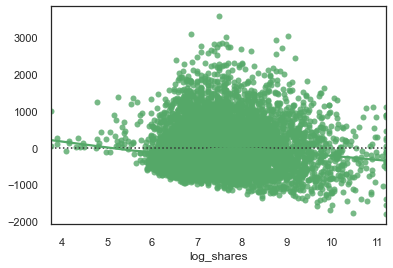

In [126]:
sns.residplot(y_test, y_pred, lowess=True, color="g")

In [128]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=8)

selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [129]:
selected_columns

Index(['entertainment', 'is_weekend', 'LDA_02', 'LDA_03',
       'global_subjectivity', 'log_kw_max_avg', 'log_kw_avg_avg',
       'log_self_ref_avg_shares'],
      dtype='object')

In [130]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = np.exp(lm_kbest.predict(X_train[selected_columns]))


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = np.exp(lm_kbest.predict(X_test[selected_columns]))

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 1936.1932189713261
Testing Root Mean Squared Error: 1935.6284211029206
Original:  1978.5252215240598 vs. KBest:  1935.6284211029206


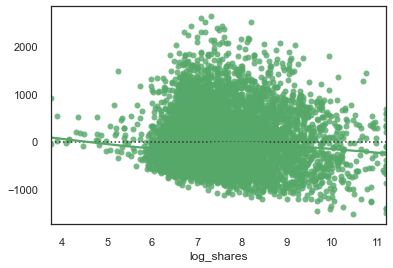

In [131]:
sns.residplot(y_test, y_kbest, lowess=True, color="g")

Training Error: 1788.2752813709267
Testing Error: 1818.1499433352867


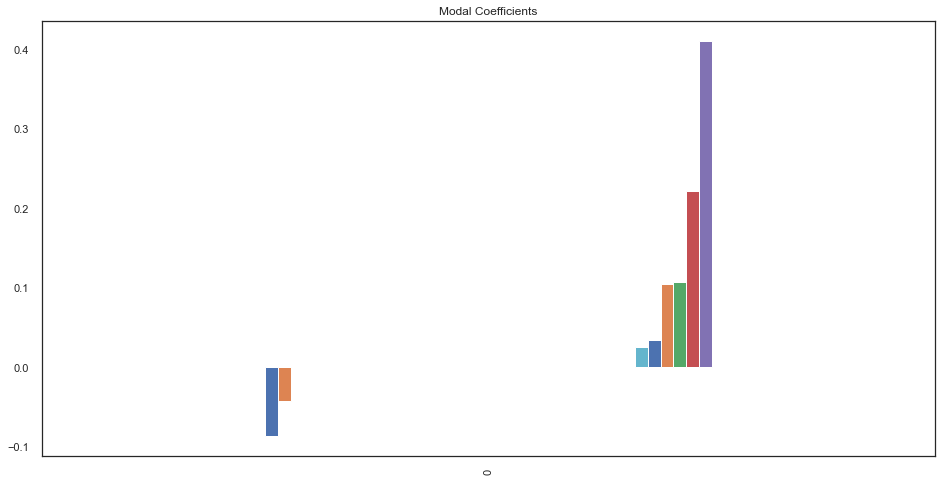

In [137]:
## training the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.02, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred_lasso = np.exp(lasso.predict(X_train))
y_pred_lasso = np.exp(lasso.predict(X_test))

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [135]:
coefficient = lasso_coef01.T
coefficient[coefficient[0] != 0]

,0
entertainment,-0.086229
LDA_02,-0.041709
global_subjectivity,0.025557
tech,0.034357
log_kw_max_avg,0.104833
is_weekend,0.107462
log_self_ref_avg_shares,0.222154
log_kw_avg_avg,0.411133


In [ ]:
sns.residplot( y_test, y_pred_lasso, lowess=True, color="g")

In [ ]:
X_train.corr() > .9

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})